# Lab 4: Sequential Data

This lab is based on an assignment developed by Prof. Lisa Zhang.

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.
5. Understand how transfer learning can be applied to NLP projects.

### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/18gyrKh81dk43EUh5adXq-VOI2klXf9z4?usp=sharing

# PART A - Spam Detection [30 pt]

In this part we will construct a LSTM model for identifying spam from non spam messages.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Part 1. Data Cleaning [10 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
file_dir = '/content/SMSSpamCollection'

In [ ]:
f = open(file_dir)
print(f.readline())
print(f.readline())
print(f.readline())
print(f.readline())
print(f.readline())

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

ham	Ok lar... Joking wif u oni...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham	U dun say so early hor... U c already then say...

ham	Nah I don't think he goes to usf, he lives around here though



In [ ]:
for f in open(file_dir):
    if 'ham' in f:
      print(f)
      break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



In [ ]:
for f in open(file_dir):
    if 'spam' in f:
      print(f)
      break

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



Label value for spam message : spam

Label value for non-spam messages : ham

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
# Initializing counts for ham and spam
ham = 0
spam = 0

for f in open(file_dir):
  if f[:3] == 'ham':
    ham += 1
  if f[:3] == 'spa':
    spam += 1
print('Total Ham Count:{}'.format(ham))
print('Total Spam Count: {}'.format(spam))

Total Ham Count:4827
Total Spam Count: 747


### Part (c) [2 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages:

1. Since, SMS language does not follow any specific pattern of english language, similar example is tweets with random words, emoji, alphanumeric context etc. So, its become more important to generate or predict text on character level.

2. Due to limitation in the character types wrt numbers as comapared to words, its easy to process inputs.


Disadvantages:

1. There is too much randomness in training these SMS models as the SMS contains very differernt character with no specific related context. So the hot encoding embedding becomes very large & expensive to train

2. Tuning becomes complex in case to generate texts with relative context


### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext


text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)        # to turn each character into an integer index
          
                                        
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset(file_dir, # name of the file
                                              "tsv",               # fields are separated by a tab
                                              fields)


In [ ]:
dataset[2].sms

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [ ]:
dataset[2].label

1

In [ ]:
SEED =1234
torch.manual_seed(SEED)


train, valid, test = dataset.split(split_ratio= [0.6,0.2,0.2],random_state= random.seed(SEED))
len(train),len(valid),len(test)

(3343, 1115, 1114)

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

In [ ]:
# Counting the numbers of spam messages in new train.exmaples with modified multiplication
new_train_spam = []
for item in train.examples:
    if item.label == 1:
        new_train_spam.append(item)

In [ ]:
len(new_train_spam),len(train.examples)

(3199, 6085)

In [ ]:
# trying to get the ratio of spam messages in modified train. example
len(new_train_spam)/len(train.examples)

0.5257189811010682

The ratio is almost balanced with 51% spam messages in the training dataset

Balanced training set is always preferred for training as number of classification should have equal numbers to avoid any bias in the output prediction. If one class is more in number then the model will be better in predicting one class and it will biased for the other class.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
vocab_stoi = text_field.vocab.stoi
#vocab_stoi

text_field.vocab.stoi represent:  Collections of default dict instance mapping token strings to numerical identifiers

In [ ]:
vocab_itos = text_field.vocab.itos
#vocab_itos

text_field.vocab.itos represent: A list of token strings indexed by their numerical identifiers

In [ ]:
vocab_size = len(text_field.vocab)
vocab_size

114

### Part (g) [1 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

"unk" represents : "unknown token" -  it is used to replace the rare words that did not fit in your vocabulary. So your sentence My name is TuhinRanjan will be translated into My name is _unk_

"PAD" represents :  GPU processes the training data in batches and all the sequences in the batch should have the same length. If the max length of the sequence is 8, the sentence My name is TuhinRanjan will be padded from either side to fit this length: My name is TuhinRanjan _pad_ _pad_ _pad_ _pad_

### Part (h) [1 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
i = 0
input_length = [0]*10 
num_pads = [0]*10 

for batch in train_iter:
  if i < 10:
    for text in batch.sms[0]:
      input_length[i] = len(text) #max(batch.sms[1])
      for char in text:
        if char == text_field.vocab.stoi["<pad>"]:
          num_pads[i] += 1
    i += 1        

print('Maximum lengths of input sequence in each batch:',input_length)
print('Number of pad tokens used in each batch:',num_pads)

Maximum lengths of input sequence in each batch: [132, 76, 34, 24, 44, 153, 101, 114, 28, 146]
Number of pad tokens used in each batch: [34, 46, 18, 12, 27, 0, 62, 6, 24, 0]


## Part 2. Model Building [5 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

#ident = torch.eye(vocab_size)
#print(ident[0]) # one-hot vector
#print(ident[1]) # one-hot vector
#x = torch.tensor([[1, 2], [3, 4]])
#print(ident[x]) # one-hot vectors

In [ ]:
class SpamRNN_1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SpamRNN_1, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
class SpamRNN_2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SpamRNN_2, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(torch.max(out, dim=1)[0])
        return out

In [ ]:
class SpamRNN_3(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SpamRNN_3, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
        return out

## Part 3. Training [8 pt]

### Part (a) [2 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data_iter):

    correct, total = 0, 0
   
    for data in iter(data_iter):
      output = model(data.sms[0])
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(data.label.view_as(pred)).sum().item()
      total += data.label.shape[0]
      return correct/total*100


In [ ]:
def valid_loss(model, data_iter, batch_size):
   n = 0
   loss = 0
   criterion = nn.CrossEntropyLoss()
   for data in data_iter:
     output = model(data.sms[0])
     loss = criterion(output, data.label)
     loss += loss.item()
     n += 1
   valid_loss = float(loss)/batch_size 
   return valid_loss

### Part (b) [2 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
def train_SpamRNN(model, train, valid, batch_size=1, num_epochs=1, lr=0.001):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()
  #model.cuda()
  
  iters, train_losses,valid_losses, train_acc, val_acc = [], [], [], [], []
  n = 0
    
  train_iter = torchtext.legacy.data.BucketIterator(train,
                                              batch_size=batch_size,
                                              sort_key=lambda x: len(x.sms),     
                                              sort_within_batch=True,
                                              repeat=False)
  valid_iter = torchtext.legacy.data.BucketIterator(valid, 
                                              batch_size=batch_size, 
                                              sort_key=lambda x: len(x.sms), 
                                              sort_within_batch=True,
                                              repeat=False)
  
  for epoch in range(num_epochs):
    
    for data in iter(train_iter):

      # cleanup
      optimizer.zero_grad()
      # forward pass
      output = model(data.sms[0])
      loss = criterion(output, data.label)
      # backward pass
      loss.backward()
      optimizer.step()
      
      n += 1 # increment iteration count

      iters.append(n)

      train_losses.append(float(loss)/batch_size) # appending the training losses
      valid_losses.append(valid_loss(model, valid_iter, batch_size)) #appending the validation losses
      
      train_acc.append(get_accuracy(model,train_iter)) #appending the training accuracy
      val_acc.append(get_accuracy(model,valid_iter)) #appending the validation accuracy


    
  # plotting
  plt.title("Training Curve")
  plt.plot(iters, train_losses, label="Train")
  plt.plot(iters, valid_losses, label="Valid")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

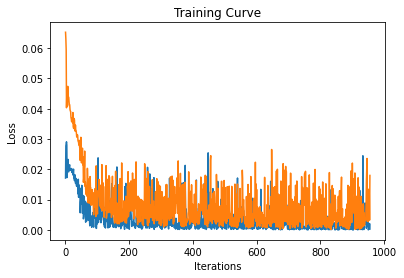

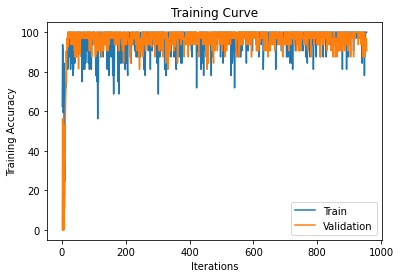

Final Training Accuracy: 100.0
Final Validation Accuracy: 90.625


In [ ]:
model1 = SpamRNN_2(vocab_size,8,2)
train_SpamRNN(model1, train,valid, batch_size=32, num_epochs=5, lr=0.01)

### Part (c) [2 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

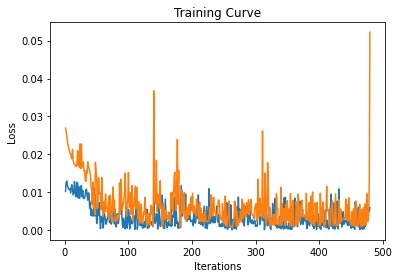

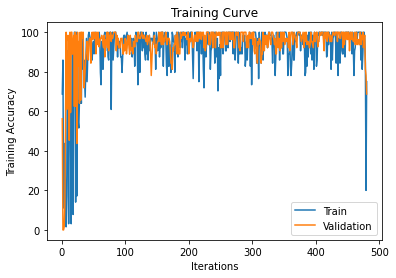

Final Training Accuracy: 75.0
Final Validation Accuracy: 68.75


In [ ]:
model2 = SpamRNN_1(vocab_size,16,2)
train_SpamRNN(model2, train,valid, batch_size=64, num_epochs=5, lr=0.01)

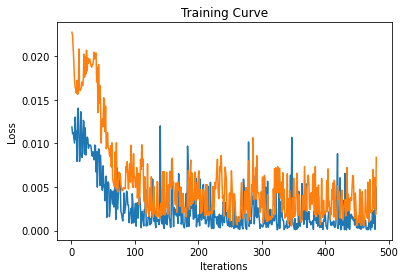

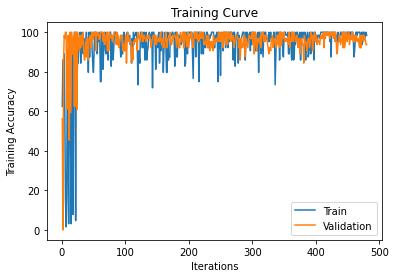

Final Training Accuracy: 98.4375
Final Validation Accuracy: 93.75


In [ ]:
model3 = SpamRNN_2(vocab_size,16,2)
train_SpamRNN(model3, train,valid, batch_size=64, num_epochs=5, lr=0.01)

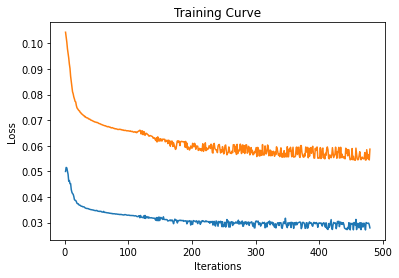

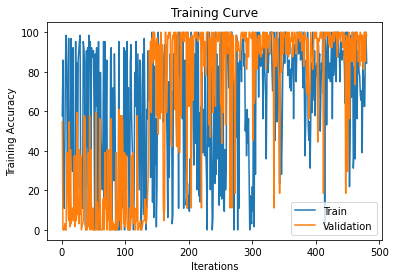

Final Training Accuracy: 84.375
Final Validation Accuracy: 98.4375


In [ ]:
model4 = SpamRNN_3(vocab_size,16,2)
train_SpamRNN(model4, train,valid, batch_size=64, num_epochs=5, lr=0.01)

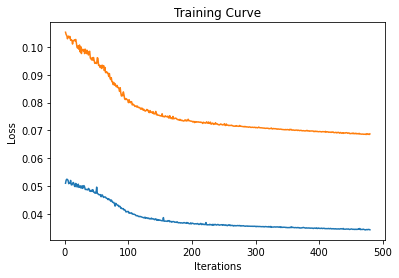

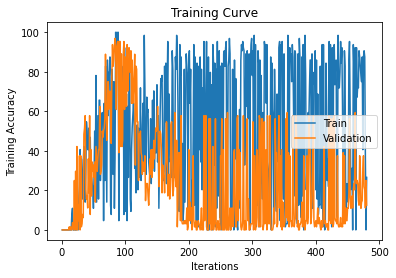

Final Training Accuracy: 26.5625
Final Validation Accuracy: 12.5


In [ ]:
model5 = SpamRNN_3(vocab_size,16,2)
train_SpamRNN(model5, train,valid, batch_size=64, num_epochs=5, lr=0.001)

### Part (d) [1 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
#valid_spam = torchtext.legacy.data.Dataset(
 #   [e for e in valid.examples if e.label == 1],
  #  valid.fields)
# Create a Dataset of only non-spam validation examples
#valid_nospam = None # TODO

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

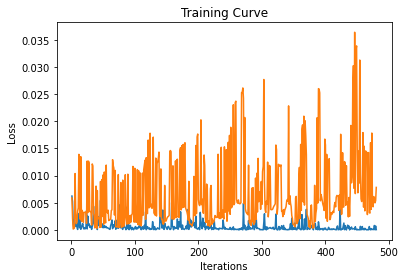

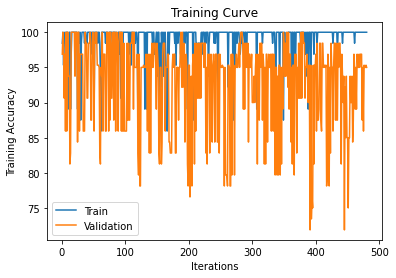

Final Training Accuracy: 100.0
Final Validation Accuracy: 95.0


In [ ]:
#model6 = SpamRNN_2(vocab_size,10,2)
train_SpamRNN(model3, train,valid_spam, batch_size=64, num_epochs=5, lr=0.01)

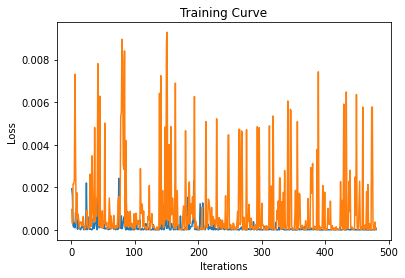

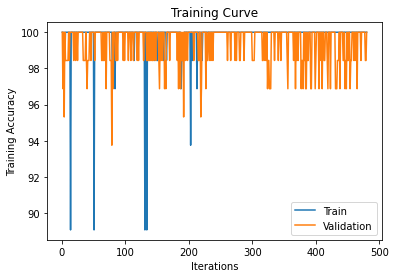

Final Training Accuracy: 100.0
Final Validation Accuracy: 100.0


In [ ]:
#model7 = SpamRNN_2(vocab_size,10,2)
train_SpamRNN(model3, train,valid_nospam, batch_size=64, num_epochs=5, lr=0.01)

### Part (e) [1 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

False Positive Impact: It will creat a choas and confusion in the user mind since, the prediction over here states that its a spam but in reality it is not spam.

False Negative Impact: The user will be fooled by the spammer as in this case the prediction is no spam but it is a spam in reality

## Part 4. Evaluation [7 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_iter = torchtext.legacy.data.BucketIterator(test, 
                                              batch_size=64, 
                                              sort_key=lambda x: len(x.sms), 
                                              sort_within_batch=True,
                                              repeat=False)

In [ ]:
get_accuracy(model3, test_iter)

98.4375

### Part (b) [1 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam test examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam test examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

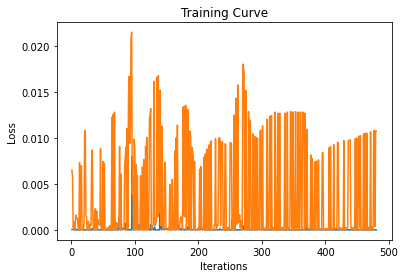

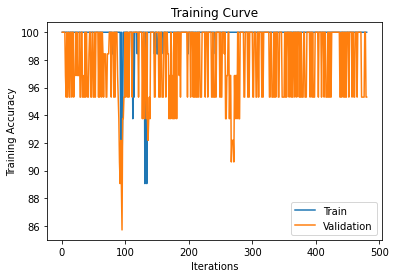

Final Training Accuracy: 100.0
Final Validation Accuracy: 95.3125


In [ ]:
#model8 = SpamRNN_2(vocab_size,10,2)
train_SpamRNN(model3, train,test_spam, batch_size=64, num_epochs=5, lr=0.01)

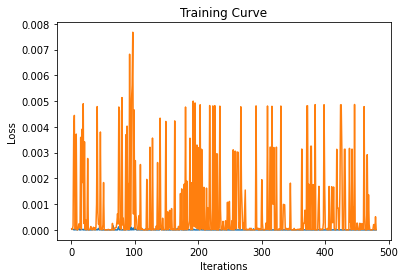

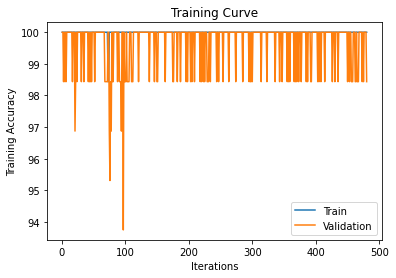

Final Training Accuracy: 100.0
Final Validation Accuracy: 98.4375


In [ ]:
#model9 = SpamRNN_2(vocab_size,10,2)
train_SpamRNN(model3, train,test_nospam, batch_size=64, num_epochs=5, lr=0.01)

### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"

In [ ]:
def get_new_msg(msg):
    message = msg
    idxs = [text_field.vocab.stoi[w]        # lookup the index of word
            for w in message
            if w in text_field.vocab.stoi] # keep words that has an embedding
    idxs = torch.tensor(idxs) # convert list to pytorch tensor
    return idxs

In [ ]:
new_msg = get_new_msg(msg)
#print(new_msg.shape)

out = torch.sigmoid(model3(new_msg.unsqueeze(0)))
print("Spam Probability Distribution of message (No Spam , Spam):",format(out))
pred = out.max(1, keepdim=True)[1]

print(pred)
prediction = pred.item()
if prediction > 0:
  print("Spam Message")
else:
  print("No Spam Message")



Spam Probability Distribution of message (No Spam , Spam): tensor([[0.9948, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0]])
No Spam Message


In [ ]:
text = "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [ ]:
new_msg = get_new_msg(text)
#print(new_msg.shape)

out = torch.sigmoid(model3(new_msg.unsqueeze(0)))
print("Spam Probability Distribution of message (No Spam , Spam):",format(out))
pred = out.max(1, keepdim=True)[1]

print(pred)
prediction = pred.item()
if prediction > 0:
  print("Spam Message")
else:
  print("No Spam Message")


Spam Probability Distribution of message (No Spam , Spam): tensor([[2.7818e-04, 9.9989e-01]], grad_fn=<SigmoidBackward0>)
tensor([[1]])
Spam Message


### Part (d) [2 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Detecting spam is a difficult task as the spammers are continously working to nulfiy the detection practices, so its always evolving.

As of now, all the models are working on the fundamentals of feed forward loop where we tune everything in advance in search for better output with very less errors. The optimization works in feed back loop to make the whole process looks like in feed forward control. 

The model i would like to build will take the output prediction as the comparison factor to the actual input and will calcaulate the error or deviation. Further that deviation factor will be taken as a token to reinitialize the gradient to give an output with 95% COI(adjustable) and will iterate for the next iterations. This model probably wont need much hidden layers as the output-input token will cover up for the loss of the hidden layers. 

# PART B - Transfer Learning [20 pt]

In this part we will compare our earlier model with one that takes advantage of a generative RNN model to improve the prediction. There are several ways to implement transfer learning with RNNs, here we will use an approach known as ULMFiT developed by fastai. Rather than rebuilding the model from scratch, we will take advantage of the fastai library.

Provided below is some helper code to get you started.

#### Helper Code

In [ ]:
# install relevant libraries
!pip install fastai

In [ ]:
# load relevant libraries
from fastai import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text import *

In [ ]:
# download SPAM data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip smsspamcollection.zip

--2021-11-20 21:10:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K   337KB/s    in 0.6s    

2021-11-20 21:10:49 (337 KB/s) - ‘smsspamcollection.zip’ saved [203415/203415]

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: SMSSpamCollection       
  inflating: readme                  


This time we will load the data using pandas.

In [ ]:
# set up data and verify
df1 = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
df1.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# check distribution
df1['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

Split the data into training and validation datasets.

In [ ]:
# split the data and check dimensions

from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df1, stratify = df1['target'], test_size = 0.4, random_state = 42)

In [ ]:
# split data into testing and validation set
df_val, df_test = train_test_split(df_val, stratify = df_val['target'], test_size = 0.5, random_state = 42)

In [ ]:
df_trn.shape, df_val.shape, df_test.shape

((3343, 2), (1114, 2), (1115, 2))

In [ ]:
df_trn['target'].value_counts(),df_val['target'].value_counts(),df_test['target'].value_counts()

(ham     2895
 spam     448
 Name: target, dtype: int64, ham     965
 spam    149
 Name: target, dtype: int64, ham     965
 spam    150
 Name: target, dtype: int64)

In [ ]:
# save the original training examples
#old_train_examples = train.examples
# get all the spam messages in `train`
#train_spam = []
#for item in train.examples:
#    if item.label == 1:
#        train_spam.append(item)
# duplicate each spam message 6 more times
#train.examples = old_train_examples + train_spam * 6

### Create the language model
Esentially, the language model contains the structure of the language (English in this case), allowing us to quickly use in a classification model, skipping the part of learning the semantics of the language from scratch.

Creating a language model from scratch can be intensive due to the sheer size of data. Instead we will download the pre-trained model, which is a neural network (NN) with an AWD_LSTM architecture. By setting pretrained = True we say to fastai to download the weights from the trained model (a corpus of 103 MM of wikipedia articles).

In [ ]:
# create pretrained language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


### Testing the language model


In [ ]:
for i in range(5):
  print(lang_mod.predict("The problem usually starts when", n_words=10))

The problem usually starts when the 674 team comes to their bottom in the mid
The problem usually starts when Bucks are picked out as a single group (
The problem usually starts when a situation is more normal : in the first place
The problem usually starts when the " show is simply missing , for each or
The problem usually starts when there are too much other problems to be found ,


Each time we excecute the `predict`, we get a different random sentence, completed with the number of choosen words (`n_words`).

Try your own sentences!

### Fine-tuning the language model
The language model that we have "loaded" is great for generating wikipedia-like sentances, but here we're more interested in generating data like our email dataset. 

Make sure to enable GPU for this step or it make takes several hours to train.

In [ ]:
# fine-tune language model data
lang_mod.fit_one_cycle(4, max_lr= 5e-02)
lang_mod.freeze_to(-1)
lang_mod.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))
lang_mod.freeze_to(-2)
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))
lang_mod.unfreeze()
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

# save language model
lang_mod.save_encoder('my_awsome_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,5.584334,4.803138,0.185714,00:05
1,4.875803,4.494593,0.185714,00:05
2,4.419443,4.406842,0.271429,00:05
3,4.122954,4.400613,0.242857,00:05


epoch,train_loss,valid_loss,accuracy,time
0,3.615088,4.356857,0.271429,00:05
1,3.580695,4.352233,0.242857,00:05
2,3.517533,4.352946,0.257143,00:05


epoch,train_loss,valid_loss,accuracy,time
0,3.421791,4.309705,0.271429,00:05
1,3.411806,4.301889,0.285714,00:05
2,3.394997,4.306728,0.300000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,3.353244,4.285129,0.300000,00:06
1,3.320617,4.248589,0.271429,00:06
2,3.297194,4.254620,0.285714,00:06


### Classification model
Now we can train a classification model that will identify spam and non-spam messages. Since we used a fastai language model, it will be easier to just continue working with the fastai library.

In [ ]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn,  valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
data_clas.show_batch()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
"xxbos xxmaj sad story of a xxmaj man - xxmaj last week was my b'day . xxmaj my xxmaj wife did'nt wish me . xxmaj my xxmaj parents forgot n so did my xxmaj kids . i went to work . xxmaj even my xxmaj colleagues did not wish . xxmaj as i entered my cabin my xxup pa said , '' xxmaj happy xxmaj b'day xxmaj boss ! !",ham
"xxbos < # > % of pple marry with their xxunk ... xxunk they hav gud xxunk dat xxunk problems . i sent dis 2 u , u wil get gud news on friday by d person you like . xxmaj and tomorrow will be the best day of your life . xxmaj do nt break this xxunk . xxmaj if you break you will xxunk . send this to",ham
"xxbos xxmaj is n't frnd a xxunk in life ? imagine urself xxunk a frnd .. xxunk u feel at ur xxunk ? xxunk u do xxunk ur cell ? wat abt xxunk ? thnk abt xxunk xxunk cared , missed & & xxunk u ? xxunk it to all those dear - loving frnds xxunk whom u ca nt live .. i jst did it .. xxmaj xxunk ..",ham
"xxbos xxmaj honeybee xxmaj said : * i 'm d xxmaj sweetest in d xxmaj world * xxmaj god xxmaj laughed & & xxmaj said : * xxmaj wait , u xxmaj havnt xxmaj met d xxmaj person xxmaj reading xxmaj this xxmaj msg * xxup moral : xxmaj even xxup god xxmaj can xxmaj crack xxmaj jokes ! xxup gm+gn+ge+gn : )",ham
"xxbos xxmaj honeybee xxmaj said : * i 'm d xxmaj sweetest in d xxmaj world * xxmaj god xxmaj laughed & & xxmaj said : * xxmaj wait , u xxmaj havnt xxmaj met d xxmaj person xxmaj reading xxmaj this xxmaj msg * xxup moral : xxmaj even xxup god xxmaj can xxmaj crack xxmaj jokes ! xxup gm+gn+ge+gn : )",ham


In [ ]:
# create the classifier
learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch = AWD_LSTM)

In [ ]:
# load language model
learn_classifier.load_encoder('my_awsome_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3343 items)
x: TextList
xxbos xxup interflora - xxunk 's not too late to order xxmaj interflora xxunk for christmas call 0800 xxunk to place your order before xxmaj midnight tomorrow .,xxbos i dunno lei ... xxmaj like dun haf ...,xxbos xxmaj xxunk , xxunk , xxunk post , xxunk dis , < # > .,xxbos xxmaj yeah , i 'll leave in a couple minutes & & let you know when i get to mu,xxbos meet you in xxunk st outside gap … you can see how my mind is working !
y: CategoryList
spam,ham,ham,ham,ham
Path: .;

Valid: LabelList (1114 items)
x: TextList
xxbos :( but your not here xxrep 4 .,xxbos xxmaj haha better late than ever , any way i could swing by ?,xxbos xxmaj finally it has happened .. ! xxmaj aftr xxunk .. ! xxup xxunk is now cheaper than xxup xxunk ! xxmaj the xxunk xxunk us to " xxup drink " . . . xxmaj but do n't " xxup drive ",xxbos i only haf xxunk . xxmaj it 's xxunk,xxbos xxmaj do nt think you need xxunk card for uk travel . xxmaj a

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-01
Min loss divided by 10: 4.37E-02


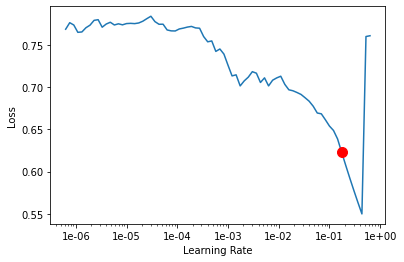

In [ ]:
# train classifier
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [ ]:
learn_classifier.fit_one_cycle(5, max_lr=1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.429035,0.109293,0.977558,00:07
1,0.205558,0.095035,0.983842,00:07
2,0.138852,0.084436,0.984740,00:07
3,0.127634,0.078074,0.986535,00:07
4,0.094267,0.082424,0.985637,00:06


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

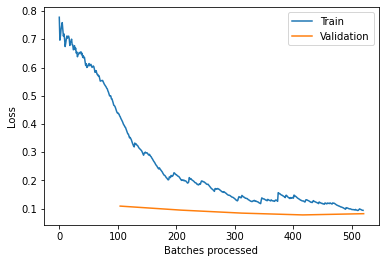

In [ ]:
learn_classifier.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.00E-06


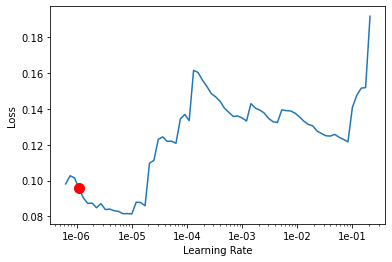

In [ ]:
lang_mod.freeze_to(-1)

learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

Test out the classification model on spam and non-spam examples.

In [ ]:
# predict
learn_classifier.predict('did you buy the groceries for dinner? :)')

(Category tensor(0), tensor(0), tensor([0.9955, 0.0045]))

In [ ]:
# predict
learn_classifier.predict('Free entry call back now')

(Category tensor(0), tensor(0), tensor([0.5357, 0.4643]))

Next we will evaluate on all of our validation data.

In [ ]:
# get predictions from validation
valid_preds, valid_label=learn_classifier.get_preds(ds_type=DatasetType.Valid, ordered=True)
valid_preds.shape

torch.Size([1114, 2])

## Part 1. Evaluate Performance [10pt]

### Part (a) [5pt]

Implement the above helper code for spam detection. 

What is the accuracy obtained with ULMFiT? How does ULMFiT compare to the approach in the first part using only LSTM?

In [ ]:
# add a column with the predictions on the test set

df_test['spam_pred'] = df_test['text'].apply(lambda row:str(learn_classifier.predict(row)[0]))

In [ ]:
# print the accuracy against the test set
print("Accuracy: {}".format(accuracy_score(df_test['target'],df_test['spam_pred'])*100))

Accuracy: 98.65470852017937


In [ ]:
df_test1=df_test
df_test1.to_csv('df_test1')

In [ ]:
df_test1.head()

,target,text,spam_pred
4559,ham,PISS IS TALKING IS SOMEONE THAT REALISE U THAT...,ham
3544,ham,I'm e person who's doing e sms survey...,ham
5489,ham,Oh thanks a lot..i already bought 2 eggs ..,ham
382,ham,"Yeah sure, give me a couple minutes to track d...",ham
836,ham,Good Morning my Dear........... Have a great &...,ham


In [ ]:
fields = [('target', label_field), ('text', text_field)]

In [ ]:
dataset_test = torchtext.legacy.data.TabularDataset("/content/df_test1", # name of the file
                                              "csv",               # fields are separated by a tab
                                              fields)

In [ ]:
test_iter1 = torchtext.legacy.data.BucketIterator(dataset_test, 
                                              batch_size=len(dataset_test)-1, 
                                              sort_key=lambda x: len(x.text), 
                                              sort_within_batch=True,
                                              repeat=False)

In [ ]:
#Defining a function to predict the label of the text message in the dataframe
def testing(message):
  out = torch.sigmoid(model3(new_msg.unsqueeze(0)))
  pred = out.max(1, keepdim=True)[1]
 
  predict = pred.item()
  return predict

In [ ]:
df_test1['spam_pred_custom_model'] = df_test1['text'].apply(lambda row:str(testing(row)))

In [ ]:
df_test1.head()

,target,text,spam_pred,spam_pred_custom_model
4559,ham,PISS IS TALKING IS SOMEONE THAT REALISE U THAT...,ham,1
3544,ham,I'm e person who's doing e sms survey...,ham,1
5489,ham,Oh thanks a lot..i already bought 2 eggs ..,ham,1
382,ham,"Yeah sure, give me a couple minutes to track d...",ham,1
836,ham,Good Morning my Dear........... Have a great &...,ham,1


In [ ]:
df_pred=df_test1['spam_pred_custom_model'].replace({'1':'ham','0':'spam'})

In [ ]:
df_pred.head()

4559    ham
3544    ham
5489    ham
382     ham
836     ham
Name: spam_pred_custom_model, dtype: object

In [ ]:
df_true = df_test['target']

In [ ]:
# print the accuracy against the test set
print("Accuracy: {}".format((accuracy_score(df_pred,df_true))*100))

Accuracy: 86.54708520179372


### Part (b) [5pt]
Provide a confusion matrix of the performance for the two models. How do they compare? Are there any qualitative differences between the performances (i.e. examine the samples for which the models differred)?

In [ ]:
import matplotlib.pyplot as plt
# Taken from the scikit-learn documentation
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

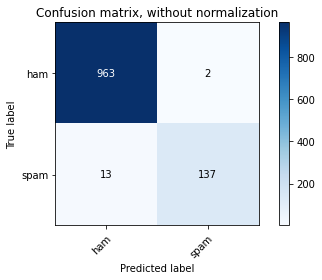

In [ ]:
# plot the confusion matrix for the test set
plot_confusion_matrix(df_test['target'],df_test['spam_pred'],
                      classes=['ham','spam'])
plt.show()

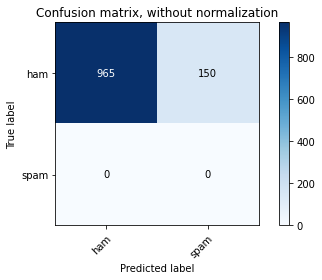

In [ ]:
# plot the confusion matrix for the test set
plot_confusion_matrix(df_pred,df_true,
                      classes=['ham','spam'])
plt.show()

Both the models have very comparable performances. The custom one results in detecting 0 spam messages but the transfer learning model can detect resonable ones. 

The reason for the bad result of the custom model can be :   
1. Less varinace of spam training set data
2. More complex model and more tuning strategy requirement
3. Multiple splitting and data leakage

## Part 2. Evaluate on New Data [10pt]

### Part (a) [4pt]
What is your model's prediction of the probability that the SMS message "machine learning is sooo cool!" is spam?

In [ ]:
# predict
learn_classifier.predict('machine learning is sooo cool!"')

(Category tensor(0), tensor(0), tensor([1.0000e+00, 1.1438e-06]))

No spam prediction!!!

### Part (b) [3 pt] 
Load 5 sample sentences from your spam mail and test it out out the two models you created. How well do they perform?

In [ ]:
email1= "Subject: jump in to gain substantial ground immediatelyvwe are very excited about this new upcoming stock about to explode montana oil and gas , inc . ( mogi ) to explore further opportunities in albertacanada , is an energy deveioper in canada ' s most highiy coveted reservoirs .aggressive investors and traders may want to watch montana oi | and gasagain this morning ! montana oil and gas inc . ( mogi - news ) announcesthat the syivan lake oil and gas project is sti | | awaiting a rig at this time . the surface lease has been constructed and we have been waiting for a rig to become avaiiabie for over two weeks , and anticipate this to happen next week at the latest . the company has a 25 % working interest in the syivan lake project . symbo | - mogi current price - . 26 reasons to consider mogi "

#ULMFiT model
# predict
learn_classifier.predict(email1)

(Category tensor(0), tensor(0), tensor([0.7302, 0.2698]))

In [ ]:
# Part A model
new_msg = get_new_msg(email1)

out = torch.sigmoid(model3(new_msg.unsqueeze(0)))
print("Spam Probability Distribution of message (No Spam , Spam):",format(out))
pred = out.max(1, keepdim=True)[1]

print(pred)
prediction = pred.item()
if prediction > 0:
  print("Spam Email")
else:
  print("No Spam Email")

Spam Probability Distribution of message (No Spam , Spam): tensor([[0.9484, 0.0650]], grad_fn=<SigmoidBackward0>)
tensor([[0]])
No Spam Email


Both models predicted wrong

In [ ]:
email2= "Subject: jennifer sends them to their final destination . designated as a private key 4 . validate public keys .someone wants to meet you ! who your match could be , find here to the purported owner . you"

#ULMFiT model
# predict
print(learn_classifier.predict(email2))

# Part A model
new_msg = get_new_msg(email2)

out = torch.sigmoid(model3(new_msg.unsqueeze(0)))
print("Spam Probability Distribution of message (No Spam , Spam):",format(out))
pred = out.max(1, keepdim=True)[1]

print(pred)
prediction = pred.item()
if prediction > 0:
  print("Spam Email")
else:
  print("No Spam Email")

(Category tensor(0), tensor(0), tensor([0.8535, 0.1465]))
Spam Probability Distribution of message (No Spam , Spam): tensor([[0.9958, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0]])
No Spam Email


Both models predicted wrong

In [ ]:
email3= "Dear Tuhin Ranjan, Get instant Cash Loan at Zero Percent Interest Rate"
#ULMFiT model
# predict
print(learn_classifier.predict(email3))

# Part A model
new_msg = get_new_msg(email3)

out = torch.sigmoid(model3(new_msg.unsqueeze(0)))
print("Spam Probability Distribution of message (No Spam , Spam):",format(out))
pred = out.max(1, keepdim=True)[1]

print(pred)
prediction = pred.item()
if prediction > 0:
  print("Spam Email")
else:
  print("No Spam Email")

(Category tensor(0), tensor(0), tensor([0.5791, 0.4209]))
Spam Probability Distribution of message (No Spam , Spam): tensor([[0.9898, 0.0107]], grad_fn=<SigmoidBackward0>)
tensor([[0]])
No Spam Email


Both models predicted wrong

In [ ]:
email4= "Get Apple iPhone 12 Pro Max Free*"
#ULMFiT model
# predict
print(learn_classifier.predict(email4))

# Part A model
new_msg = get_new_msg(email4)

out = torch.sigmoid(model3(new_msg.unsqueeze(0)))
print("Spam Probability Distribution of message (No Spam , Spam):",format(out))
pred = out.max(1, keepdim=True)[1]

print(pred)
prediction = pred.item()
if prediction > 0:
  print("Spam Email")
else:
  print("No Spam Email")

(Category tensor(0), tensor(0), tensor([0.7625, 0.2375]))
Spam Probability Distribution of message (No Spam , Spam): tensor([[0.9087, 0.0915]], grad_fn=<SigmoidBackward0>)
tensor([[0]])
No Spam Email


Both models predicted wrong

In [ ]:
email5= "I am not into playing games or wasting mine or your time. I am REAL!!(THAT IS ME IN ALL OF MY PICS!). I am respectful; I am discreet; and I am FUN! So, if you want to come hang out, talk, get a massage, etc., I'll be waiting to hear from you!  MASSAGE ME HERE> http://www.xaxnv.com/aff_c?offer_id=14334&aff_id=20485&aff_sub=Subel.xx Its Free just verify your email and give me direct call"

#ULMFiT model
# predict
print(learn_classifier.predict(email5))

# Part A model
new_msg = get_new_msg(email5)

out = torch.sigmoid(model3(new_msg.unsqueeze(0)))
print("Spam Probability Distribution of message (No Spam , Spam):",format(out))
pred = out.max(1, keepdim=True)[1]

print(pred)
prediction = pred.item()
if prediction > 0:
  print("Spam Email")
else:
  print("No Spam Email")

(Category tensor(1), tensor(1), tensor([0.2693, 0.7307]))
Spam Probability Distribution of message (No Spam , Spam): tensor([[0.0173, 0.9930]], grad_fn=<SigmoidBackward0>)
tensor([[1]])
Spam Email


Both models predicted right

### Part (c) [3pt]
Load 5 sample sentences from your regular mail and test it out out the two models you created. How well do they perform?

In [ ]:
email6= "Subject: deal # 502952 daren ,the above deal number expired at the end of november 2000 and needs to eitherbe extended through december , or a new deal inputted . can you assist me inthis ?thanks .mike"

#ULMFiT model
# predict
print(learn_classifier.predict(email6))

# Part A model
new_msg = get_new_msg(email6)

out = torch.sigmoid(model3(new_msg.unsqueeze(0)))
print("Spam Probability Distribution of message (No Spam , Spam):",format(out))
pred = out.max(1, keepdim=True)[1]

print(pred)
prediction = pred.item()
if prediction > 0:
  print("Spam Email")
else:
  print("No Spam Email")

(Category tensor(0), tensor(0), tensor([0.6818, 0.3182]))
Spam Probability Distribution of message (No Spam , Spam): tensor([[0.0030, 0.9988]], grad_fn=<SigmoidBackward0>)
tensor([[1]])
Spam Email


Transfer learning model predicted right, while custom model predicted wrong

In [ ]:
email7= "Subject: ehronline web address change this message is intended for ehronline users only . due to a recent change to ehronline , the url ( aka  web address  ) for accessing ehronline needs to be changed on your computer . the change involves adding the letter  s  to the  http  reference in the url . the url for accessing ehronline should be : https : / / ehronline . enron . com . this change should be made by those who have added the url as a favorite on the browser"
#ULMFiT model
# predict
print(learn_classifier.predict(email7))

# Part A model
new_msg = get_new_msg(email7)

out = torch.sigmoid(model3(new_msg.unsqueeze(0)))
print("Spam Probability Distribution of message (No Spam , Spam):",format(out))
pred = out.max(1, keepdim=True)[1]

print(pred)
prediction = pred.item()
if prediction > 0:
  print("Spam Email")
else:
  print("No Spam Email")

(Category tensor(0), tensor(0), tensor([0.5029, 0.4971]))
Spam Probability Distribution of message (No Spam , Spam): tensor([[4.4462e-04, 9.9979e-01]], grad_fn=<SigmoidBackward0>)
tensor([[1]])
Spam Email


Transfer learning model predicted right, while custom model predicted wrong

In [ ]:
email8= "Subject: re : cornhusker john , i have a draft that i have been working on revising - - got pulled off to work on triple lutz again and may not have anything to distribute until late next week - - i will be out of the office on triple lutz the rest of today and tomorrow and then out of town until the 25 th - - i will try to get something to you to look at before i go but can make no guarantees - - sandi john griffith @ enron 10 / 17 / 2000 08 : 17 am to : sandi m braband / hou / ect @ ect cc : subject : cornhusker sandi , what is going on with cornhusker ? have we made any progress on the agreement ? please let me know where we stand . thanks . john"

#ULMFiT model
# predict
print(learn_classifier.predict(email8))

# Part A model
new_msg = get_new_msg(email8)

out = torch.sigmoid(model3(new_msg.unsqueeze(0)))
print("Spam Probability Distribution of message (No Spam , Spam):",format(out))
pred = out.max(1, keepdim=True)[1]

print(pred)
prediction = pred.item()
if prediction > 0:
  print("Spam Email")
else:
  print("No Spam Email")

(Category tensor(0), tensor(0), tensor([0.9616, 0.0384]))
Spam Probability Distribution of message (No Spam , Spam): tensor([[0.0033, 0.9986]], grad_fn=<SigmoidBackward0>)
tensor([[1]])
Spam Email


Transfer learning model predicted right, while custom model predicted wrong

In [ ]:
email9= "Subject: notes from initial enom use case meeting - 2 / 2 / 00 attached are the notes captured from the whiteboard and discussions on wednesday ( as best as i can decipher ) . please note the next steps we discussed : commitment of key subject experts ( who , how much time dedicated ) establishment of the project steering team detail out high level use cases thanks for your participation in the meeting , and i look forward to working with you to create another great system . - hal x 66277"

#ULMFiT model
# predict
print(learn_classifier.predict(email9))

# Part A model
new_msg = get_new_msg(email9)

out = torch.sigmoid(model3(new_msg.unsqueeze(0)))
print("Spam Probability Distribution of message (No Spam , Spam):",format(out))
pred = out.max(1, keepdim=True)[1]

print(pred)
prediction = pred.item()
if prediction > 0:
  print("Spam Email")
else:
  print("No Spam Email")

(Category tensor(0), tensor(0), tensor([0.7715, 0.2285]))
Spam Probability Distribution of message (No Spam , Spam): tensor([[0.0029, 0.9987]], grad_fn=<SigmoidBackward0>)
tensor([[1]])
Spam Email


Transfer learning model predicted right, while custom model predicted wrong

In [ ]:
email10= "Subject: copanno changes - - - - - - - - - - - - - - - - - - - - - - forwarded by ami chokshi / corp / enron on 01 / 28 / 2000 10 : 58 am - - - - - - - - - - - - - - - - - - - - - - - - - - - troy _ a _ benoit @ reliantenergy . com on 01 / 28 / 2000 10 : 53 : 30 am to : ami chokshi / corp / enron @ enron cc : subject : copanno changes ( see attached file : hpl - jan . xls ) - hpl - jan . xls "
#ULMFiT model
# predict
print(learn_classifier.predict(email10))

# Part A model
new_msg = get_new_msg(email10)

out = torch.sigmoid(model3(new_msg.unsqueeze(0)))
print("Spam Probability Distribution of message (No Spam , Spam):",format(out))
pred = out.max(1, keepdim=True)[1]

print(pred)
prediction = pred.item()
if prediction > 0:
  print("Spam Email")
else:
  print("No Spam Email")

(Category tensor(1), tensor(1), tensor([0.3743, 0.6257]))
Spam Probability Distribution of message (No Spam , Spam): tensor([[0.0046, 0.9981]], grad_fn=<SigmoidBackward0>)
tensor([[1]])
Spam Email


Both models predicted wrong

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [1]:
%%shell
jupyter nbconvert --to html /content/sample_data/LAB_4_Sequential_Data.ipynb

[NbConvertApp] Converting notebook /content/sample_data/LAB_4_Sequential_Data.ipynb to html
[NbConvertApp] Writing 1188936 bytes to /content/sample_data/LAB_4_Sequential_Data.html


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus